<a href="https://colab.research.google.com/github/AwaisAli37405/Deep_Learning_with_fast_ai/blob/master/Deep_Learning_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
# !pip install -U fastprogress fastai

### In order to use the built in datasets available in fast ai untar_data. It can be downloaded and decompresses using the following line of code:

In [ ]:
path = untar_data(URLs.PETS)/'images'
# print(path)
# path.ls()

### IT will download the dataset once and will return the location. Now we will use the factory method that is a great way to get your data quickly ready for training - get image file. It is a fastai function that helps us grab all the image files (recursively) in one folder.

In [ ]:
files = get_image_files(path)
len(files)


### Now to get this data labeled following convention has been adopted in fast.ai. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs

In [ ]:
def is_cat(x): return x[0].isupper()


### To get our data ready for the model we need to initialize the dataloader object.
### There is function in Vision_data of fast_ai that can label the examples using names of the image files imagedataloader.from_name_fucntion

### We have passed to this function the directory we’re working in, the files we grabbed, our label_func and one last piece as item_tfms: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn’t pass this, we would get an error later as it would be impossible to batch the items together.

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))



In [ ]:
dls.show_batch()

### Then we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [73]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

### If you want to make a prediction on a new image, you can use learn.predict:

In [ ]:
learn.predict(files[0])

In [ ]:
learn.show_results()

In [ ]:
# to export the models
learn.export('model.pkl')

In [ ]:
?vision_learner

## Which Image models are the best?
Pytorch has many [image models](https://timm.fast.ai/) around 500. These models are basically the mathemical functions differ on how much time, accuracy and from which family they belong.

Ross regularly [benchmarks](https://www.kaggle.com/code/jhoward/which-image-models-are-best/) new models as they are added to timm.

In [ ]:
import timm

In [ ]:
timm.list_models() # list all the models in pytorch

In [ ]:
# we want to use the covnext model - Search for model architectures by Wildcard
timm.list_models('convnext*')

In [ ]:
??(vision_learner)


Normally, models perform calculations using fp32 (Single-Precision), where each number takes up 32 bits of memory. By calling .to_fp16() on your vision_learner, you are telling the model to use Mixed Precision training.
$$
\begin{array}{|l|c|c|}
\hline
\textbf{Feature} & \textbf{FP32 (Standard)} & \textbf{FP16 (Mixed Precision)} \\ \hline
\text{Memory per value} & \text{4 Bytes (32 bits)} & \text{2 Bytes (16 bits)} \\ \hline
\text{Training Speed} & \text{Baseline} & \text{Significantly Faster} \\ \hline
\text{VRAM Usage} & \text{Higher} & \text{Lower (~50\% less)} \\ \hline
\text{Hardware Requirement} & \text{Any GPU} & \text{Modern GPU (Turing+)} \\ \hline
\end{array}
$$

In [ ]:
# so if we want to use any of these models with fast-ai vision learner we have to provide it as a string as an input
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(1)

### Understanding the `dls.vocab` Object

In fastai, the `dls.vocab` (Vocabulary) acts as the mapping system between human-readable labels and the integer indices used by the neural network.

$$
\begin{array}{|l|l|l|}
\hline
\textbf{Property/Method} & \textbf{Description} & \textbf{Example Output} \\ \hline
\text{dls.vocab} & \text{The list of unique class names} & \text{['black', 'grizzly', 'teddy']} \\ \hline
\text{len(dls.vocab)} & \text{Total number of classes (output neurons)} & \text{3} \\ \hline
\text{dls.vocab[i]} & \text{Find label string at index } i & \text{'grizzly' (for } i=1\text{)} \\ \hline
\text{dls.vocab.o2i} & \text{Dictionary mapping 'Object to Index'} & \text{\{'black': 0, 'grizzly': 1, ...\}} \\ \hline
\end{array}
$$

**Key Mathematical Concept:**
The final layer of your model outputs a vector $\mathbf{y}$ of size $N$, where $N = \text{len(dls.vocab)}$.
The probability for class $i$ is calculated such that:
$$ P(\text{class}_i) = \text{softmax}(\mathbf{y})_i $$
where the index $i$ corresponds exactly to the position in `dls.vocab`.

In [ ]:
categories  =  learn.dls.vocab

In [ ]:
print(categories) # since we have tewo categories false and true

In [ ]:
# now to map them
def classify_img(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [ ]:
classify_img(files[100])

In [ ]:
# Now if you want to look at the trianed model
model = learn.model

In [ ]:
model

In [ ]:
l = model.get_submodule('0.model.stem.1')

In [ ]:
l

In [ ]:
list(l.parameters())

## How does really a neural networks work
A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1.   Multiplies each input by a number of values. These values are known as parameters
2.   Adds them up for each group of values
3.  Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using gradient descent. Let's see how this works...

In [ ]:
from matplotlib.pyplot import title
# from ipywidgets import interact
from fastai.basics import *

# plotting a quadratic line
def plotting(f, color='r', min=-2,max=2, Title=None):
  x = torch.linspace(min, max, 500)[:,None]
  plt.plot(x, f(x), color)
  plt.title(Title)
  plt.show()



In [ ]:
def f(x):
  return 3*x**2 + 2*x +1

In [ ]:
plotting(f,min=-2,max=2)

## This quadratic is of the form $ax^2 + bx + c$, with parameters $a=3$, $b=2$, $c=1$.

To make it easier to try out different quadratics for fitting a model to the data we'll create, let's create a function that calculates the value of a point on any quadratic:

In [ ]:
def quad(a, b, c, x): return a*x**2 + b*x + c


## If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the partial function, like so:



If you want to put this explanation in your notebook:$$\underbrace{f(a, b, c, x)}_{\text{General Function}} \xrightarrow{\text{partial}(a,b,c)} \underbrace{f_{a,b,c}(x)}_{\text{Specialized Function}}$$For example, if you run f = mk_quad(3, 2, 1), then:f(1) is the same as calling quad(3, 2, 1, 1).f(10) is the same as calling quad(3, 2, 1, 10).

In [ ]:
def mk_quad(a,b,c): return partial(quad, a,b,c)

## So for instance, we can recreate our previous quadratic:

In [ ]:
f2 = mk_quad(3,2,1)
plotting(f2)

Now let's simulate making some noisy measurements of our quadratic f. We'll then use gradient descent to see if we can recreate the original function from the data.

Here's a couple of functions to add some random noise to data:

In [ ]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [ ]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

A link to numpy book [link](https://wesmckinney.com/book/)

In [ ]:
plt.scatter(x,y)

In [ ]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plotting(mk_quad(a,b,c))

In [ ]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()


In [ ]:
# @interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plotting(f,Title = (f'Loss: {loss:.2f}'))

Derivatives, which measure the rate of change of a function. Tutorial can be found [here](https://www.youtube.com/playlist?list=PLybg94GvOJ9ELZEe9s2NXTKr41Yedbw7M)

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1. Define the basic ReLU
def relu(x): return torch.clamp(x, min=0.)

# 2. Create two different "neurons"
# Neuron A: Starts at -1.0
def neuron_a(x): return relu(x + 1.0)

# Neuron B: Starts at 0.5 and is "flipped" and steeper
def neuron_b(x): return -2.0 * relu(x - 0.5)

# 3. The "Neural Network" (Adding them together)
def neural_net(x): return neuron_a(x) + neuron_b(x)

# 4. Plotting the results
x = torch.linspace(-2, 2, 100)
plt.plot(x, neuron_a(x), '--', label="Neuron A", color='blue')
plt.plot(x, neuron_b(x), '--', label="Neuron B", color='green')
plt.plot(x, neural_net(x), label="Combined Output (The Net)", color='red', linewidth=3)
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.title("How ReLUs Build Shapes")
plt.show()

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

# How images are represented in a computer

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
from fastai.vision.all import *
import fastbook
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

In [ ]:
path.ls()[0]

In [ ]:
(path/'train').ls()

In [ ]:
files = get_image_files(path)

In [ ]:

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [ ]:
threes

Here we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In [ ]:

im3 = threes[1]
print(threes[1])
Image.open(im3)

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [ ]:
array3 = np.array(Image.open(im3))[4:10,4:10]
array3

In [ ]:
print(type(Image.open(im3)))
tensor(Image.open(im3))[4:10,4:10]

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [ ]:
im3_t = tensor(Image.open(im3))
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.

In [ ]:
# now creating the tensor of images of 3 and 7
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
threes_tensors = [tensor(Image.open(o)) for o in threes]
print(len(sevens_tensors), len(threes_tensors))

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:

In [ ]:
show_image(sevens_tensors[5])

In [ ]:
sevens_tensors[0].shape

In [ ]:
# now stack the tensors and scaling to 0 and 1 Large numbers (like 255) can cause "gradient explosions" during training,
#making the model unstable. By dividing the entire stack by 255, you scale every single pixel

stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes = torch.stack(threes_tensors).float()/255

In [ ]:
stacked_sevens.shape
stacked_sevens.ndim

When you stacked your images, you created a rank-3 tensor with a shape like $(6131, 28, 28)$.
Dimension 0: This is the "index" or "page number" in your stack (the 6,131 images).
Dimension 1: The vertical rows of pixels (28 rows).
Dimension 2: The horizontal columns of pixels (28 columns).When you tell PyTorch to take the mean(0), you are telling it: "Look through the entire depth of the stack at every single $(x, y)$ coordinate and average the values you find there."

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)


How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

1. Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm

2. Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [ ]:
sample_image = stacked_sevens[0]

#calculate its distance
l1_norm = (sample_image - mean7).abs().mean()
l1_norm

In [ ]:
l2_norm = ((sample_image - mean7)**2).mean().sqrt()
l2_norm

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [ ]:
# now using the above loss function using tensor flow built in methods
F.l1_loss(sample_image, mean7)


In [ ]:
F.mse_loss(sample_image,mean7).sqrt()

## Playing around with numpy and pytorch tensors

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr

In [ ]:
tns

In [ ]:
arr.shape

In [ ]:
tns.shape

In [ ]:
tns[1]

In [ ]:
tns[1,1:3]

In [ ]:
tns+1

In [ ]:
tns.type()

In [ ]:
#will automatically change the type
tns*1.5

In [ ]:
tns

### Computing Metrics using Broadcasting

In [ ]:
# Create the validationsets
valid3_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()])
valid7_tensor = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()])

In [ ]:
valid3_tensor = valid3_tensor.float()/255
valid7_tensor = valid7_tensor.float()/255

In [ ]:
valid3_tensor.shape, valid7_tensor.shape

Now we need to subtract each validation image from the mean image calculated above.

By using mean((-1, -2)), you are asking: "For every image in my stack, how far away is it from the ideal?" This allows you to then compare those distances to see if a specific image looks more like a 3 or a 7.

This is what you saw with (-1, -2). Just like a Python list where my_list[-1] is the last item, PyTorch counts backward from the end of the shape:

-1: The very last dimension (Columns / 28)

-2: The second-to-last dimension (Rows / 28)

-3: The third-to-last dimension (Number of images / 6131)

In [ ]:
# calculating the mean abs error
def distance_l1(a,b):
  return (a-b).abs().mean(dim = (-1,-2))

In [ ]:
distance_l1(sample_image, mean7)


But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, valid_3_tens, which has a shape of [1010,28,28] representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument valid_3_tens, the tensor that represents the 3s validation set:

In [ ]:
valid3_tensor_dist = distance_l1(valid3_tensor, mean3)
valid3_tensor_dist

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function mnist_distance, and you'll see we have there the subtraction (a-b). The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

In [ ]:
tensor([1,2,3]) + tensor(1)

So in this case, PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have

In [ ]:
(valid3_tensor - mean3).shape

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape [1010,28,28].

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).
This is true of all broadcasting and elementwise operations and functions done in PyTorch. It's the most important technique for you to know to create efficient PyTorch code.

Next in mnist_distance we see abs. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls mean((-1,-2)). The tuple (-1,-2) represents a range of axes. In Python, -1 refers to the last element, and -2 refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was (1010). In other words, for every image, we averaged the intensity of all the pixels in that image.

In [ ]:
distance_l1(valid3_tensor, mean3).shape

In [ ]:
def is_3(x): return distance_l1(x, mean3) < distance_l1(x, mean7)

In [ ]:
accuracy_3 = is_3(valid3_tensor).float().mean()
accuracy_7 = (1 - is_3(valid7_tensor).float()).mean()

In [ ]:
accuracy_3,accuracy_7,(accuracy_3+accuracy_7)/2

## Stocastic Gradient Decent

the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the derivative of a function tells you how much a change in its parameters will change its result.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.



In [ ]:
'''If you define function(x) as (x**2).sum(), then the result y = function(xt)
will already be a scalar. Because y is now a scalar tensor, you can directly
call y.backward() without needing an additional .sum() before it.

Let's break down why the gradients remain the same:

Original Scenario (function(x) returns x**2):

xt = tensor([3.0, 2.0])
y_intermediate = xt**2 -> tensor([9.0, 4.0]) (Non-scalar)
y_scalar = y_intermediate.sum() -> tensor(13.0) (Scalar)
y_scalar.backward() calculates the gradient of (x_1^2 + x_2^2) with respect to x_1 and x_2.
d(x_1^2 + x_2^2)/dx_1 = 2*x_1 = 2*3 = 6
d(x_1^2 + x_2^2)/dx_2 = 2*x_2 = 2*2 = 4
xt.grad will be tensor([6.0, 4.0]).
Your Proposed Scenario (function(x) returns (x**2).sum()):

xt = tensor([3.0, 2.0])
y = function(xt) -> (xt**2).sum() -> (tensor([9.0, 4.0])).sum() -> tensor(13.0) (Scalar)
y.backward() calculates the gradient of (x_1^2 + x_2^2) with respect to x_1 and x_2.
Again, d(x_1^2 + x_2^2)/dx_1 = 2*x_1 = 2*3 = 6
And d(x_1^2 + x_2^2)/dx_2 = 2*x_2 = 2*2 = 4
xt.grad will still be tensor([6.0, 4.0]).
In both cases, the scalar function whose gradient is being computed
is ultimately f(x_1, x_2) = x_1^2 + x_2^2. The sum() operation just
moves from being an explicit step outside the function definition
to being an implicit step within the function definition.
The mathematical result of the gradient calculation remains
consistent because the underlying scalar function (the sum of squares) is the same.'''

! [ -e /content ] && pip install -Uqq fastbook
from fastai import *
import fastbook
from fastbook import *

def function(x):
  return (x**2).sum()

xt = tensor([3.0,2.0]).requires_grad_(True) # a variable has been flagged for calcualting the gradient
print(function(xt)) # normal fnction calcualtion

y = function(xt)
y.backward()
print(xt.grad)



The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

In [ ]:
# now implementing the simulation of stocastic gradient decent

time = torch.arange(0,20).float();
time


In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [ ]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [ ]:
def mse(preds,targets):
  return ((preds - targets)**2).mean()

In [ ]:
# initialize
parms = torch.randn(3).requires_grad_()
orig_parms = parms.clone()

# predict
predictions = f(time, parms)


predictions



In [ ]:
# def show_preds(preds, ax=None):
#     # if ax is None: ax=plt.subplots()[1]
#     plt.scatter(time, speed)
#     plt.scatter(time, to_np(preds), color='red')
#     # plt.set_ylim(-300,100)


def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

In [ ]:
show_preds(predictions)

In [ ]:
loss = mse(predictions, speed)
loss

In [ ]:
loss.backward()

In [ ]:
parms.grad

In [ ]:
# now multiplying by the learning rate
parms.grad * 1e-5

In [ ]:
parms

In [ ]:
parms.grad.data

In [ ]:
parms.data

In [ ]:
parms.data -= 1e-5 * parms.grad.data

In [ ]:
parms.data

In [ ]:
parms.grad = None

In [ ]:
parms.grad

In [ ]:
# now check the mse
predictions = f(time, parms)
loss = mse(predictions, speed)
loss

In [ ]:
show_preds(predictions)

In [ ]:
# now encapsulating the above in to a function
def weights_update(parms, show = True):
  predictions = f(time, parms)
  loss = mse(predictions, speed)
  if show:
    print(loss)

  loss.backward()
  parms.data -= 1e-5*parms.grad.data
  parms.grad = None
  return predictions



In [ ]:
for i in range(100): weights_update(parms, False)

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs:
  show_preds(weights_update(parms, False), ax)
plt.tight_layout()

# Now implementing the loss and stochastic gradient decent with MNIST Dataset

In [74]:
! [ -e /content ] && pip install -Uqq fastbook
from fastai import *
import fastbook
from fastbook import *

In [75]:
path = untar_data(URLs.MNIST_SAMPLE)

<div><progress max="3214948" value="3219456"></progress> 100.14% [3219456/3214948 00:00&lt;00:00]</div>

In [76]:
path.ls()

[Path('/root/.fastai/data/mnist_sample/labels.csv'), Path('/root/.fastai/data/mnist_sample/valid'), Path('/root/.fastai/data/mnist_sample/train')]

In [111]:
stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'3').ls().sorted()])

label_3 = tensor([1]*len(stacked_threes)).reshape(-1,1) #unsqeeze(1)

stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'7').ls().sorted()])

label_7 = tensor([0]*len(stacked_sevens)).reshape(-1,1)

torch.Size([28, 28])


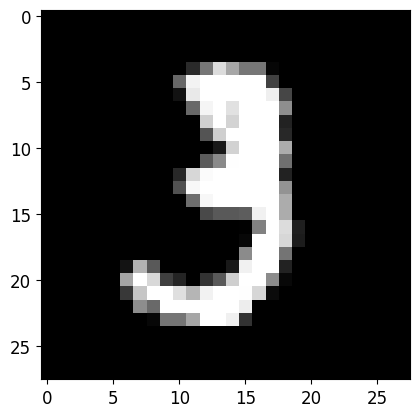

In [112]:
import matplotlib.pyplot as plt

# 1. Take the first set of pixels
img = stacked_threes[0]
print(img.shape)

# 2. Fold it into a 28x28 square (it's currently a flat line!)
# img_square = img.view(28,28)

# 3. Paint it!
plt.imshow(img, cmap='gray')

In [113]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = torch.cat([label_3, label_7])

In [114]:
train_x.shape

torch.Size([12396, 784])

In [115]:
train_y.shape

torch.Size([12396, 1])

In [116]:
# converting back to 28x28

train_x.view(-1,28,28).shape

torch.Size([12396, 28, 28])

In [118]:
dset = list(zip(train_x,train_y)) # will be used later for data loader


AttributeError: 'list' object has no attribute 'shape'